# Reinforcement Learning

# Q-Learning

This notebook presents Q-learning.

Credits: Thomas Bonald

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from model import Walk, Maze, TicTacToe, Nim, ConnectFour
from agent import Agent, OnlineControl

## Handling (state,action) value functions
We first make some basic experiments using the maze environment

In [5]:
maze = Maze()
# set parameters
maze_map = np.load('maze_small.npy')
maze.set_parameters(maze_map, (1, 0), [(3, 8)])
# init
maze = Maze()

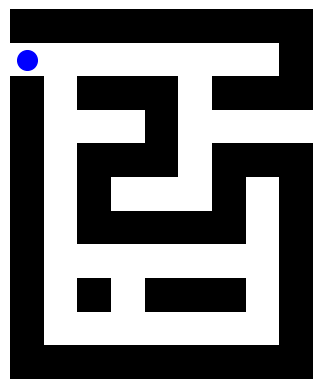

In [6]:
maze.display()

In [7]:
# Check the OnlineControl class in agent.py
control = OnlineControl(maze)

In [9]:
# Generate a idle (randomly chosen) (state,action) value function
for state in maze.get_states():
  for action in maze.get_actions(state):
    control.state_action_value[maze.encode(state)][action] = np.random.uniform(0,1)

In [12]:
# For a given state, display the values of the actions : what is the corresponding best action?
state = maze.get_states()[2]
control.state_action_value[maze.encode(state)]

defaultdict(int, {(0, 1): 0.34936827605749377, (0, -1): 0.12510360014469024})

In [13]:
# For the same state, compute the best action using get_best_action
control.get_best_action(state)

(0, 1)

In [14]:
# For the same state, compute the epsilon greedy best action
control.eps = 0.1
control.get_best_action_randomized(state)
# Discuss the impact of epsilon

(0, 1)

## Q-learning

In [1]:
class QLearning(OnlineControl):
    """Online control by Q-learning."""
        
    def update_values(self):
        """Learn the state-action value online."""
        # 1. reinit the state
        self.environment.reinit_state()
        state = self.environment.state
        # 2. choose one random action
        action = self.get_best_action_randomized(state)
        # 3. save the sate and action
        self.add_state_action(state, action)
        
        # 一步一步的处理来更新Q
        for t in range(self.n_steps):
            state_code = self.environment.encode(state)
            self.state_action_count[state_code][action] += 1
            reward, stop = self.environment.step(action)
            if stop:
                gain = reward
            else:
                # 4. Q-learning function
                new_state = self.environment.state
                new_action = self.get_best_action_randomized(new_state)
                self.add_state_action(new_state, new_action)
                new_state_code = self.environment.encode(new_state)
                # Q(s_t+1, a_t)
                best_action = self.get_best_action(new_state)
                # r_t+1 + gamma * max_a Q(s_t+1, a)
                gain = reward + self.gamma * self.state_action_value[new_state_code][best_action]

            # 5. update the Q(s_t, a_t)
            # diff = gain - Q(s_t, a_t) 
            diff = gain - self.state_action_value[state_code][action]
            self.state_action_value[state_code][action] += diff / self.state_action_count[state_code][action]
            if stop:
                break
            state = self.environment.state
            action = new_action

NameError: name 'OnlineControl' is not defined

## Maze

In [16]:
maze = Maze()
# set parameters
maze_map = np.load('maze_small.npy')
maze.set_parameters(maze_map, (1, 0), [(3, 8)])
# init
maze = Maze()

In [17]:
algo = QLearning(maze, eps=0.1, n_steps=1000)

In [19]:
n_episodes = 1000
for t in range(n_episodes):
    algo.update_values()

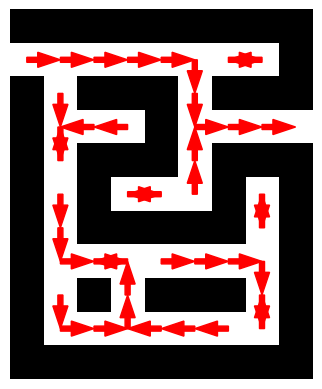

In [20]:
policy = algo.get_policy()
maze.display_policy(policy)

## Tic-Tac-Toe

In [21]:
game = TicTacToe()
agent = Agent(game)

In [54]:
agent.get_gains()

array([-1, -1, -1,  0,  1,  1,  1,  1,  1,  0, -1, -1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  0,  1, -1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  0,  1,  0,  1,  1,  0,  1,  1,  1,  1, -1,  1,  0, -1,
       -1, -1,  1,  1,  1, -1,  1,  0,  0,  1,  0, -1, -1,  0,  1, -1,  1,
        0,  1,  1, -1, -1,  0,  1,  1,  0,  0,  0,  1, -1, -1,  0,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1, -1, -1,  1, -1])

In [55]:
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([27,  5, 68]))

In [22]:
algo = QLearning(game, eps=0.5)

In [23]:
n_games = 1000
for i in range(n_games):
    algo.update_values()

In [24]:
policy = algo.get_policy()

In [25]:
agent = Agent(game, policy)

In [26]:
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 5,  7, 88]))

In [27]:
# Play against the one-step best policy defined in the first lab. Who's winning?


## Perfect adversary

Let's get a perfect adversary by Value Iteration.

In [28]:
from scipy import sparse
from dp import PolicyEvaluation

In [29]:
def dot_max(matrix: sparse.csr_matrix, vector: np.ndarray):
    """Get the dot_max product of a matrix by a vector, replacing the sum by the max."""
    return np.maximum.reduceat(vector[matrix.indices] * matrix.data, matrix.indptr[:-1])

In [30]:
class ValueIteration(PolicyEvaluation):
    """Value iteration.
    
    Parameters
    ----------
    environment: 
        The environment.
    player: 
        Player for games (1 or -1, default = 1).
    gamma:
        Discount factor (between 0 and 1).
    n_iter:
        Number of value iterations.
    tol:
        Tolerance = maximum difference between two iterations for early stopping.
    """
    
    def __init__(self, environment, player=1, gamma=1, n_iter=100, tol=0, verbose=True):
        agent = Agent(environment, player=player)
        policy = agent.policy
        super(ValueIteration, self).__init__(environment, policy, player, gamma)  
        self.n_iter = n_iter
        self.tol = tol
        self.verbose = verbose
        
   
    def get_optimal_policy(self):
        """Get the optimal policy by iteration of Bellman's optimality equation."""
        if hasattr(self.environment, 'player'):
            return self.get_optimal_policy_game()
        self.values = np.zeros(self.n_states)
        moves = self.get_transitions().astype(bool)
        for t in range(self.n_iter):
            values = self.values.copy()
            values_next = self.rewards + self.gamma * self.values
            values[self.non_terminal] = dot_max(moves[self.non_terminal], values_next)
            diff = np.max(np.abs(values - self.values))
            self.values = values
            if diff <= self.tol:
                if self.verbose:
                    print(f"Convergence after {t+1} iterations.")
                break
        policy = self.get_policy()
        return policy
    
    def get_optimal_policy_game(self):
        """Get the optimal policy for games, assuming the best response of the adversary."""
        self.values = np.zeros(self.n_states)
        moves = self.get_transitions().astype(bool)
        player = np.array([state[0] == self.player for state in self.states]) & self.non_terminal
        adversary = np.array([state[0] == -self.player for state in self.states]) & self.non_terminal
        for t in range(self.n_iter):
            values = self.values.copy()
            values_next = self.rewards + self.gamma * self.values
            values[player] = self.player * dot_max(moves[player], self.player * values_next)
            values[adversary] = -self.player * dot_max(moves[adversary], -self.player * values_next)
            diff = np.max(np.abs(values - self.values))
            self.values = values
            if diff <= self.tol:
                if self.verbose:
                    print(f"Convergence after {t+1} iterations.")
                break
        policy = self.get_policy()
        return policy

In [31]:
# get a perfect adversary
game = TicTacToe(play_first=False, player=-1)
algo = ValueIteration(game, player=-1, n_iter=10)
adversary_policy = algo.get_optimal_policy()

Convergence after 6 iterations.


In [32]:
# train against this player
game = TicTacToe(adversary_policy)
agent = Agent(game)

In [33]:
# before training
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0]), array([70, 30]))

In [34]:
algo = QLearning(game, eps=0.5)

In [35]:
# training 
n_games = 10000
for i in range(n_games):
    algo.update_values()

In [36]:
policy = algo.get_policy()
agent = Agent(game, policy)

In [37]:
np.unique(agent.get_gains(), return_counts=True)

(array([0]), array([100]))

## Nim

In [ ]:
game = Nim()
agent = Agent(game)

In [ ]:
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([50, 50]))

In [ ]:
algo = QLearning(game, eps=0.5)

In [ ]:
n_games = 1000
for i in range(n_games):
    algo.update_values()

In [ ]:
policy = algo.get_policy()
agent = Agent(game, policy)

In [ ]:
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 7, 93]))

## Connect Four

In [ ]:
game = ConnectFour()
agent = Agent(game)

In [ ]:
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([45, 55]))

In [ ]:
algo = QLearning(game, eps=0.5)

In [ ]:
n_games = 100
for i in range(n_games):
    algo.update_values()

In [ ]:
policy = algo.get_policy()
agent = Agent(game, policy)

In [ ]:
# no gain... can you guess why?
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([51, 49]))

In [ ]:
# Fix the issue (if any) and play against the one-step best policy defined in the first lab. Who's winning?